# 1. Regresión logística
  ##     Agustín Jofré Millet

In [8]:
""" Practica 2 
    Agustín Jofré Millet"""

import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
from pandas.io.parsers import read_csv
from numpy.linalg import inv


#lectura acrchivo
data = read_csv("ex2data1.csv", header=None).values

X_d = data[:,:2].astype(float)
y = data[:,2].astype(float)

print(X_d.shape)

# nuemro de ejemplos de entrenamiento
m = len(y)

(100, 2)


## 1.1. Visualización de los datos

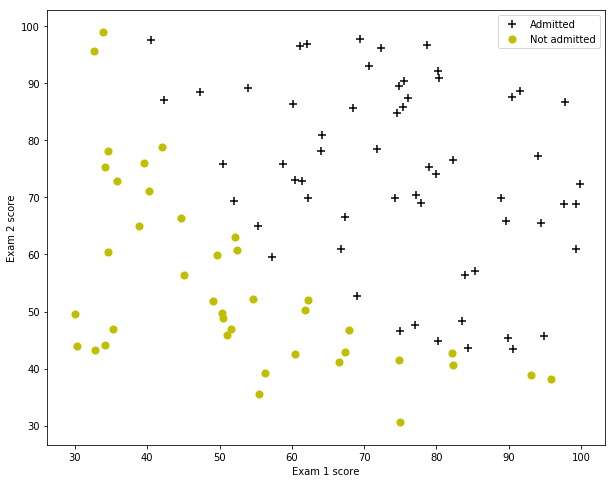

In [11]:
#Obtiene un vector con los índices de los ejemplos positivos y negativos
def visualizaDatos(X,y, x_label, y_label, label1, label2) :   
    pos = np.where(y == 1)
    neg = np.where(y == 0)

    plt.figure(figsize=(10,8))

    plt.scatter(X[pos, 0], X[pos, 1],s=50, c = 'k', marker='+', label=label1)
    plt.scatter(X[neg, 0], X[neg, 1],s=50, c = 'y', marker='o', label=label2)

    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.legend(loc='upper right')

visualizaDatos(X_d , y, 'Exam 1 score', 'Exam 2 score','Admitted','Not admitted')

## 1.2. Función sigmoide
\begin{equation*}
g(z) =
\frac{1} {1+e^{-z} }
\end{equation*}




In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## 1.3. Cálculo de la función de coste y su gradiente

\begin{equation*}
h_\theta(x) = 
\frac{1} {1+e^{-\theta^Tx} }
\end{equation*}

\begin{equation*}
J(\theta) = 
-\frac{1}{m} ((log(g(X\theta)))^T y + (log (1 - g(X\theta)))^T(1 - y))  
\end{equation*}



In [13]:
def costFunction(theta, X, y):
    hipTX = sigmoid(np.dot(X, theta))
    
    return - (np.dot(y, np.log(hipTX).T) + np.dot(np.log(1 - hipTX).T, (1 - y))) / m

\begin{equation*}
\frac{\delta J(\theta)} {{\delta}{ \theta_j}}  = 
\frac{1}{m} X^T(g(X\theta) -y)
\end{equation*}

In [14]:
def gradientFunction(theta, X, y):
    hipTX = sigmoid(np.dot(X, theta))
    
    return np.dot(X.T, (hipTX -y)) / m

In [15]:
X = np.hstack((np.ones((X_d.shape[0],1)), X_d))

theta = np.zeros(X.shape[1]) # 3
print(X.shape, y.shape, theta.shape)

(100, 3) (100,) (3,)


In [16]:
J = costFunction(theta, X, y)
gradient = gradientFunction(theta, X, y)

print(J)
print (gradient)

0.6931471805599452
[ -0.1        -12.00921659 -11.26284221]


## 1.4. Cálculo del valor óptimo de los parámetros
Se utiliza la función scipy.optimize.fmin_tnc de SciPy,
Esta función recibe tres parametros:
    El nombre de la función a optimizar,
    Un vector con los valores iniciales de los pesos a optimizar.
    El nombre de la función que calcula el gradiente de la función a optimizar.
    Un cuarto parametro extra: Una tupla con argumentos extra, si es que los hay, que se han de pasar tanto a la función a optimizar como a la que calcula su gradiente. En este caso las matrices X e Y .

In [17]:
import scipy.optimize as opt

result = opt.fmin_tnc(costFunction, theta, gradientFunction, args=(X,y))
theta_opt = result[0]
coste_opt = costFunction(theta_opt, X, y)
result
print(coste_opt)

0.20349770158947492


<Figure size 432x288 with 0 Axes>

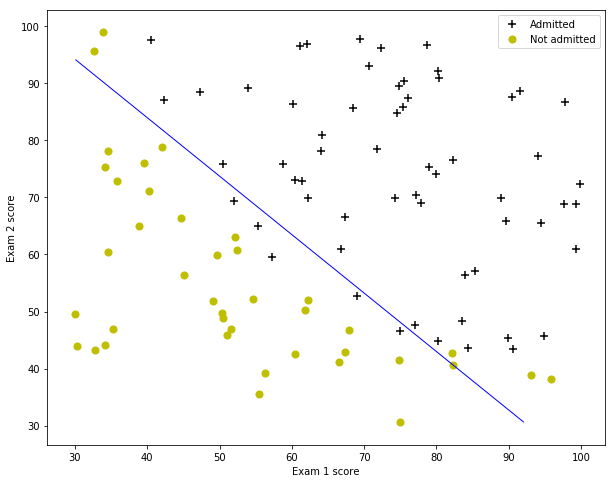

In [18]:
def plot_decisionboundary(X, Y, theta):
 
    plt.figure()
    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
    x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max),np.linspace(x2_min, x2_max))
    
    visualizaDatos(X,Y, 'Exam 1 score', 'Exam 2 score', 'Admitted','Not admitted')
    
    h = sigmoid(np.c_[np.ones((xx1.ravel().shape[0], 1)),xx1.ravel(),xx2.ravel()].dot(theta))
    h = h.reshape(xx1.shape)
    plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b')

plot_decisionboundary(X_d, y, theta_opt)

## 1.5. Evaluación de la regresión logística
 Función que calcula el porcentaje de ejemplos de entrenamiento que se clasifican usando \theta obtenido para calcular el valor de la función sigmiode sobre cada ejemoplo de entrenamiento. 
#### Si el resultado es >= 0,5 alumno admitido (1) en caso contrario no lo será (0).

In [19]:
def evaluacion (theta, X):
    hip = sigmoid(np.dot(X, theta))
    result =  [1 if x >= 0.5 else 0 for x in hip]
    return np.sum(result==y) / len(result) * 100 #a favor(igual en y , result) partido total

In [20]:
print("Porcentaje", evaluacion (theta_opt, X), "%")


Porcentaje 89.0 %


# 2. Regresión logística regularizada
En este apartado utilizarás la regresión logística regularizada para encontrar una función que pueda predecir si un microchip pasará o no el control de calidad, a partir del resultado de dos tests a los que se somete a los microchips.

In [21]:
#lectura acrchivo
data = read_csv("ex2data2.csv", header=None).values

X = data[:,:2].astype(float)
y = data[:,2].astype(float)

# nuemro de ejemplos de entrenamiento
m = len(y)

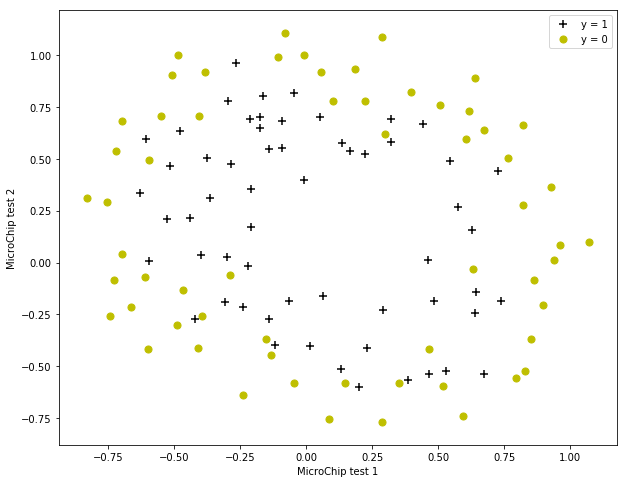

In [22]:
visualizaDatos(X, y, 'MicroChip test 1', 'MicroChip test 2', 'y = 1', 'y = 0')

## 2.1. Mapeo de los atributos

Adicion de nuevos atributos a la descripcion de los ejemplos.
Se utiliza la clase sklearn.preprocessing.PolynomialFeatures para extender cada ejemplo de entrenamiento con los términos polinómicos de x1 y x2 hasta la sexta potencia ( 28 atributos para cada ejemplo)

In [31]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(6)

x2 = poly.fit_transform(X)
print(x2.shape)
print(X.shape)


(118, 28)
(118, 2)


## 2.2. Cálculo de la función de coste y su gradiente

### Función de coste
\begin{equation*}
J(\theta) = 
-\frac{1}{m} ((log(g(X\theta)))^T y + (log (1 - g(X\theta)))^T(1 - y)) + \frac {\lambda}{2m} \sum_{j=1}^n \theta_j^2
\end{equation*}



In [24]:
def costFunction2(theta, X, y, l):
    hipTX = sigmoid(np.dot(X, theta))
    
    return - ((np.dot(y, np.log(hipTX).T) + np.dot(np.log(1 - hipTX).T, (1 - y))) / m) + l/(2*m) * np.sum(np.square(theta[1:]))

### Gradiente
\begin{equation*}
\frac{\delta J(\theta)} {{\delta}{ \theta_j}}  = 
\frac{1}{m} X^T(g(X\theta) -y) + \frac {\lambda}{m} \theta_j
\end{equation*}

In [25]:
def gradientFunction2(theta, X, y, l):
    hipTX = sigmoid(np.dot(X, theta))
    thetaSinCero = np.insert(theta[1:], 0, 0)
    return (np.dot(X.T, (hipTX -y)) / m) + (l * thetaSinCero) / m

In [26]:
theta = np.zeros(x2.shape[1]) # tam 28 atrib 
J = costFunction2(theta, x2, y, 1)
print("vector theta con ceros y lambda a 1 el coste inicial", J)

gradient = gradientFunction2(theta, x2, y, 1)
print (gradient)


vector theta con ceros y lambda a 1 el coste inicial 0.6931471805599453
[8.47457627e-03 1.87880932e-02 7.77711864e-05 5.03446395e-02
 1.15013308e-02 3.76648474e-02 1.83559872e-02 7.32393391e-03
 8.19244468e-03 2.34764889e-02 3.93486234e-02 2.23923907e-03
 1.28600503e-02 3.09593720e-03 3.93028171e-02 1.99707467e-02
 4.32983232e-03 3.38643902e-03 5.83822078e-03 4.47629067e-03
 3.10079849e-02 3.10312442e-02 1.09740238e-03 6.31570797e-03
 4.08503006e-04 7.26504316e-03 1.37646175e-03 3.87936363e-02]


## 2.3. Cálculo del valor óptimo de los parámetros

 Se utiliza la función scipy.optimize.fmin_tnc para obtener el valor óptimo de theta para la versión regularizada de la función de coste.

In [27]:
import scipy.optimize as opt

result = opt.fmin_tnc(costFunction2, theta, gradientFunction2, args=(x2,y,1))
theta_opt = result[0]
coste_opt = costFunction2(theta_opt, x2, y,1)
print(theta_opt)
print("coste optimo",coste_opt)

[ 1.27271026  0.62529964  1.18111686 -2.019874   -0.91743189 -1.43166928
  0.12393228 -0.36553118 -0.35725405 -0.17516292 -1.45817008 -0.05098418
 -0.61558558 -0.27469165 -1.19271298 -0.2421784  -0.20603303 -0.04466177
 -0.27778948 -0.29539514 -0.45645981 -1.04319154  0.02779373 -0.29244865
  0.01555759 -0.32742403 -0.14389149 -0.92467488]
coste optimo 0.5290027299645137


<Figure size 432x288 with 0 Axes>

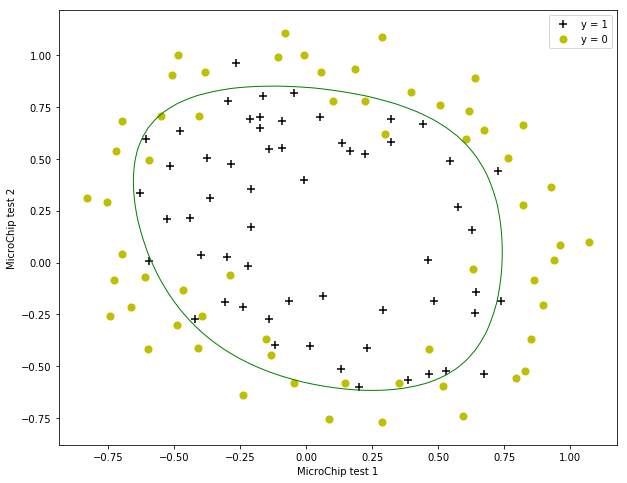

In [28]:
def plot_decisionboundary2(X, Y, theta, poly):
    plt.figure()
    visualizaDatos(X,Y, 'MicroChip test 1', 'MicroChip test 2', 'y = 1', 'y = 0')
        
    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
    x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(theta))
    h = h.reshape(xx1.shape)
    plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='g')
    plt.savefig("boundary.pdf")

plot_decisionboundary2(X, y, theta_opt, poly)

## 2.4. Efectos de la regularización
Se experimenta con distintos valores del parámetro lambda para ver cómo afecta el término de regularización al aprendizaje logístico.

Con el valor 0 se ajusta mucho a los datos, por lo que no es bueno y con valores altos de lambda , el limite no sigue los datos correctamente.


<Figure size 432x288 with 0 Axes>

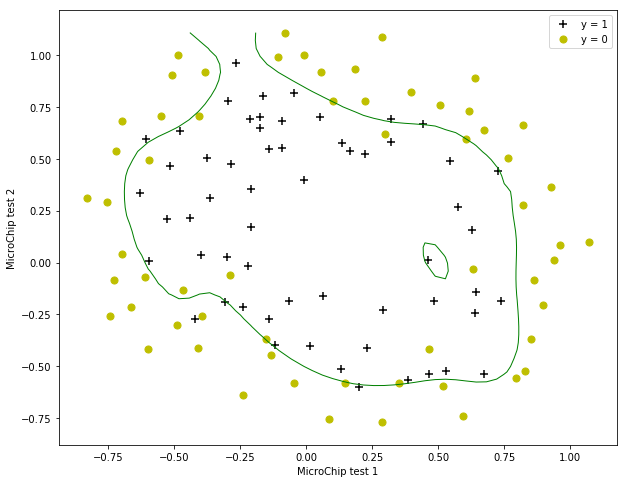

<Figure size 432x288 with 0 Axes>

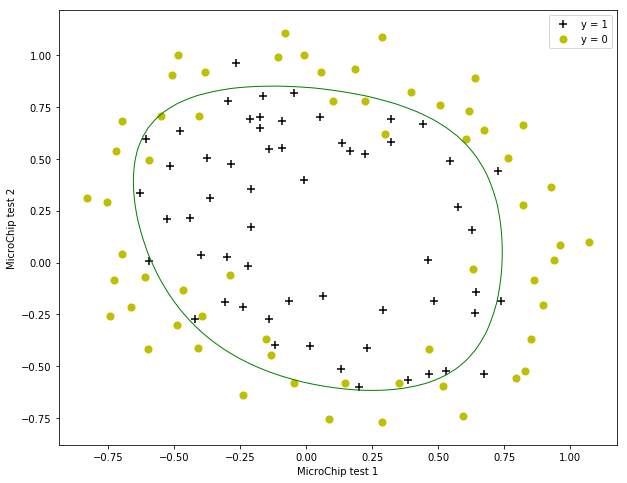

<Figure size 432x288 with 0 Axes>

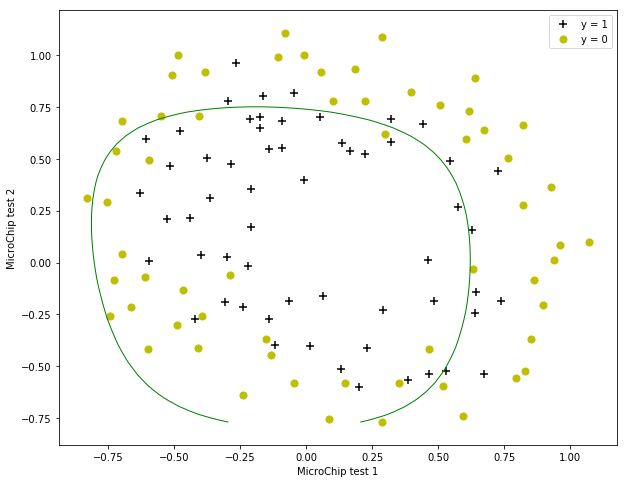

<Figure size 432x288 with 0 Axes>

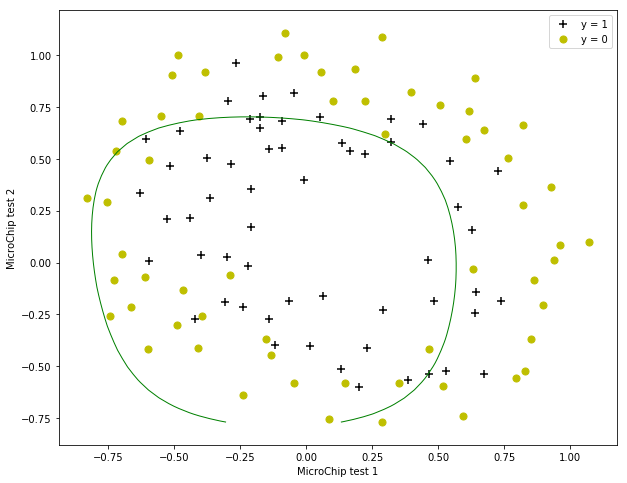

<Figure size 432x288 with 0 Axes>

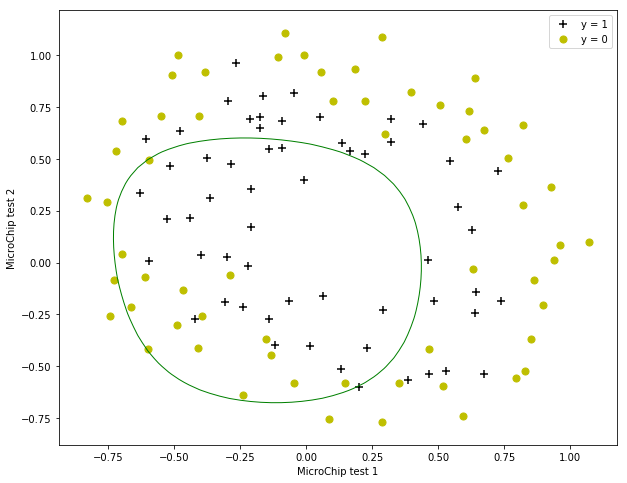

In [29]:
lambdaList = [0, 1 , 25, 50 , 100]

for i in lambdaList:
    result = opt.fmin_tnc(costFunction2, theta, gradientFunction2, args=(x2,y,i))
    theta_opt = result[0]
    plot_decisionboundary2(X, y, theta_opt, poly)